In [1]:
import dash
from dash import dcc
from dash import html
import plotly.express as px
import pandas as pd
import requests
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from datetime import datetime, timedelta
import time

# Trending coins

In [2]:
trending_coins_url = 'https://api.coingecko.com/api/v3/search/trending'
trending_coins_info = requests.get(trending_coins_url).json()

In [3]:
print('Trending coins:')
for coin in trending_coins_info['coins']:
    try:
        url = f'''https://api.coingecko.com/api/v3/coins/{coin['item']['id']}?localization=en&tickers=false&market_data=true&community_data=false&developer_data=false&sparkline=false'''
        data = requests.get(url).json()
        print(f'''coin: {coin['item']['name']}, ticker: {coin['item']['symbol']}, market cap rank: {data['market_cap_rank']}, current price: {data['market_data']['current_price']['usd']}, perc price change in 24h: {round(data['market_data']['price_change_percentage_24h'], 2)}, perc market cap change in 24h: {round(data['market_data']['market_cap_change_percentage_24h_in_currency']['usd'], 2)}''')
        
    except KeyError:
        continue

Trending coins:
coin: Baby Doge Coin, ticker: BABYDOGE, market cap rank: 144, current price: 1.899e-09, perc price change in 24h: 38.85, perc market cap change in 24h: 37.1
coin: XCAD Network, ticker: XCAD, market cap rank: 306, current price: 3.72, perc price change in 24h: 38.54, perc market cap change in 24h: 39.05
coin: Terra, ticker: LUNA, market cap rank: 84, current price: 0.0001018, perc price change in 24h: -21.51, perc market cap change in 24h: -20.78
coin: ConstitutionDAO, ticker: PEOPLE, market cap rank: 191, current price: 0.04049652, perc price change in 24h: 134.43, perc market cap change in 24h: 128.1
coin: TerraUSD, ticker: UST, market cap rank: 100, current price: 0.04877409, perc price change in 24h: -22.61, perc market cap change in 24h: -22.66
coin: Fantom, ticker: FTM, market cap rank: 60, current price: 0.44602, perc price change in 24h: 35.28, perc market cap change in 24h: 35.62
coin: Gods Unchained, ticker: GODS, market cap rank: 478, current price: 1.27, perc

In [4]:
#add mini plots for each trending coin with previous price (green or red, depending whether the price has risen in the last 7 days)
#-- ^ done --
#with 2-day prediction, printed in gray color
#add 'look up your coin' function, where it would return data on the coin similiar to the one presented in trending coins section
#with price data, market cap data, previous price and predictions
#maybe add crypto thumbnails for each trending cc?
#possibly: integration with Binance or other cc market for historical price data
# -- ^ done --
#rewrite notebook to .py script

# Global Crypto Data

In [5]:
gcd_url = 'https://api.coingecko.com/api/v3/global'
gcd = requests.get(gcd_url).json()['data']

In [6]:
#updated_at -> send cryptocurrency data to db with the timestamp
#updates approx. every 0.25hr

In [7]:
pd.DataFrame({'timestamp': [pd.to_datetime(gcd['updated_at'], unit='s')], 'total_volume_usd': [gcd['total_volume']['usd']], 'active_cryptocurrencies': [gcd['active_cryptocurrencies']], 'market_cap_usd': [gcd['total_market_cap']['usd']],
             'btc_market_cap_perc': [gcd['market_cap_percentage']['btc']], 'eth_market_cap_perc': [gcd['market_cap_percentage']['eth']],
             'alts_market_cap_perc': [100-gcd['market_cap_percentage']['btc']-gcd['market_cap_percentage']['eth']]})

,timestamp,total_volume_usd,active_cryptocurrencies,market_cap_usd,btc_market_cap_perc,eth_market_cap_perc,alts_market_cap_perc
0,2022-05-21 17:43:35,6.107235e+10,13424,1.319012e+12,42.558751,18.118855,39.322394


In [8]:
#add total_volume_usd, market_cap_usd mini plots + short term predictions

# Retrieving crypto market data for trending coins 

In [9]:
supported_exchanges = ['FTX', 'Binance', 'OKX']

In [10]:
temp_for_df = []
for coin in trending_coins_info['coins']:
    url = f'''https://api.coingecko.com/api/v3/coins/{coin['item']['id']}/tickers'''
    time.sleep(3) #prevents being rate limited
    r = requests.get(url).json()
    tmp = []
    for ticker in r['tickers']:
        if (ticker['market']['name'] in supported_exchanges) and (ticker['is_stale'] == False):
            tmp.append([ticker['market']['name'], ticker['base'], ticker['target'], ticker['volume']])
    try:
        temp_for_df.append(pd.DataFrame(tmp, columns=['exchange', 'base', 'quote', 'volume']).sort_values(by='volume', ascending=False).head(1).values[0])
    except IndexError:
        continue

In [11]:
where_to_look_for_interesting_coins = pd.DataFrame(temp_for_df, columns=['exchange', 'base', 'quote', 'volume'])

In [12]:
where_to_look_for_interesting_coins

,exchange,base,quote,volume
0,OKX,BABYDOGE,USDT,5.920576e+15
1,Binance,LUNA,BUSD,2.159722e+12
2,Binance,PEOPLE,USDT,4.836597e+09
3,Binance,UST,BUSD,1.172052e+09
4,Binance,FTM,USDT,3.344565e+08
5,OKX,GODS,USDT,2.036982e+07


In [13]:
class getExchangeData(ABC):
    
    @abstractmethod
    def get_ticker_info(self):
        pass
    
    @abstractmethod
    def get_ticker_info_url(self):
        pass

    @abstractmethod
    def get_start_time(self):
        pass
    
    @abstractmethod
    def get_interval(self):
        pass
    
    @abstractmethod
    def get_column_mapping(self):
        pass

In [14]:
class getFTXData(getExchangeData):
    
    def get_ticker_info(self, base, quote, interval, days_back):
        df = pd.DataFrame(requests.get(self.get_ticker_info_url(base, quote, interval, days_back)).json()['result'])
        df = df.apply(pd.to_numeric)
        df['startTime'] = pd.to_datetime(df.startTime)
        return df.rename(columns=self.get_column_mapping())
    
    def get_ticker_info_url(self, base, quote, interval, days_back):
        return f'https://ftx.com/api/markets/{base}/{quote}/candles?resolution={self.get_interval(interval)}&start_time={self.get_start_time(days_back)}'
    
    def get_start_time(self, days_back=0, minutes_back=0):
        return str((datetime.now()-timedelta(days=days_back, minutes=minutes_back)).timestamp()).split('.')[0]    
    
    def get_interval(self, interval):
        if interval[-1:] == 's':
            return int(interval[:-1])
        elif interval[-1:] == 'm':
            return int(interval[:-1])*60
        elif interval[-1:] == 'h':
            return int(interval[:-1])*3600
    
    def get_column_mapping(self):
        return {"startTime": "date_time", "time": "timestamp"}

In [15]:
class getBinanceData(getExchangeData):
    
    def get_ticker_info(self, base, quote, interval, days_back):
        df = pd.DataFrame(requests.get(self.get_ticker_info_url(base, quote, interval, days_back)).json())
        df = df.apply(pd.to_numeric)
        df[0] = pd.to_datetime(df[0], unit='ms')
        return df.rename(columns=self.get_column_mapping())
    
    def get_ticker_info_url(self, base, quote, interval, days_back):
        return f'https://api.binance.com/api/v3/klines?symbol={base}{quote}&interval={self.get_interval(interval)}&startTime={self.get_start_time(days_back)}'
    
    def get_start_time(self, days_back=0, minutes_back=0):
        return str((datetime.now()-timedelta(days=days_back, minutes=minutes_back)).timestamp()).split('.')[0] + '000'
    
    def get_interval(self, interval):
        return interval
    
    def get_column_mapping(self):
        return {0: 'date_time', 1: 'open', 2: 'high', 3: 'low', 4: 'close', 5: 'volume', 6: 'close_timestamp', 
               7: 'quote_volume', 8: 'trades_count', 9: 'taker_base', 10: 'taker_quote', 11: 'excess_col'}

In [16]:
class getOKXData(getExchangeData):
    
    def get_ticker_info(self, base, quote, interval, days_back):
        df = pd.DataFrame(requests.get(self.get_ticker_info_url(base, quote, interval, days_back)).json()['data'])
        df = df.apply(pd.to_numeric)
        df[0] = pd.to_datetime(df[0], unit='ms')
        return df.rename(columns=self.get_column_mapping()).sort_values(by='date_time')
    
    def get_ticker_info_url(self, base, quote, interval, days_back):
        return f'https://www.okx.com/api/v5/market/candles?instId={base}-{quote}&bar={self.get_interval(interval)}&before={self.get_start_time(days_back)}'
    
    def get_start_time(self, days_back=0, minutes_back=0):
        return str((datetime.now()-timedelta(days=days_back, minutes=minutes_back)).timestamp()).split('.')[0] + '000'
    
    def get_interval(self, interval):
        return interval.upper()
    
    def get_column_mapping(self):
        return {0: 'date_time', 1: 'open', 2: 'high', 3: 'low', 4: 'close', 5: 'volumeBase', 6: 'volume'}

In [17]:
def get_price_data_for_ticker(exch, base, quote):
        if exch == 'FTX':
            return getFTXData().get_ticker_info(base, quote, '1h', 7)
        elif exch == 'Binance':
            return getBinanceData().get_ticker_info(base, quote, '1h', 7)
        elif exch == 'OKX':        
            return getOKXData().get_ticker_info(base, quote, '1h', 7)

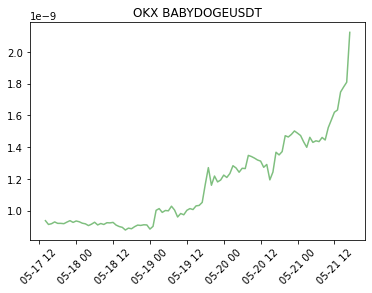

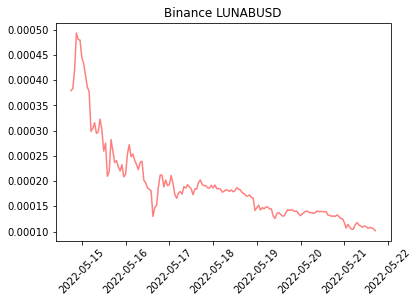

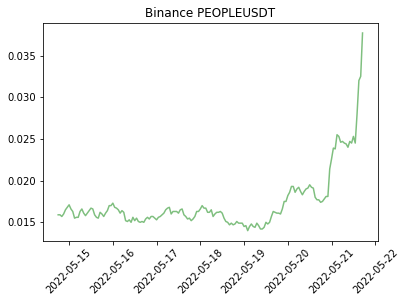

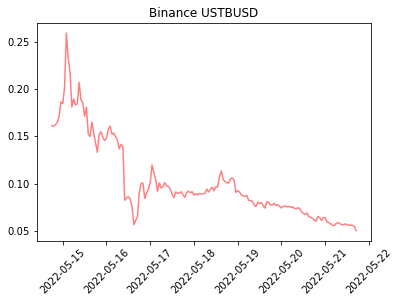

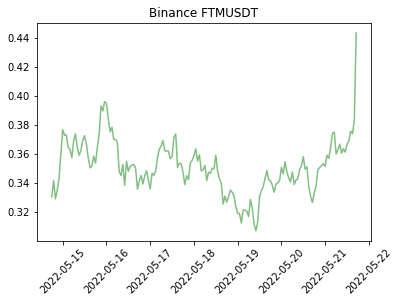

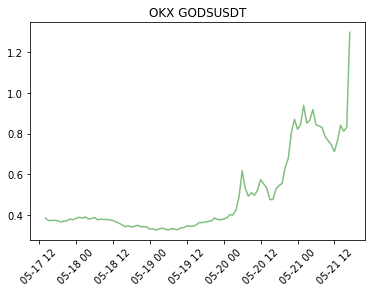

In [18]:
for row in where_to_look_for_interesting_coins.itertuples():
    plt.figure()
    df = get_price_data_for_ticker(row.exchange, row.base, row.quote)
    try:
        plt.plot(df.date_time, df.open, color=('green' if df.iloc[-1, 2] > df.iloc[0, 2] else 'red'), alpha=0.5)
        plt.xticks(rotation=45)
        plt.title(f'{row.exchange} {row.base}{row.quote}')
    except AttributeError:
        #skips if no data is available
        continue

# Look up your coin

In [19]:
#add ticker lookup for all exchanges